In [ ]:
!pip uninstall opencv-contrib-python

In [ ]:
!pip install opencv-contrib-python==3.4.17.61

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

In [ ]:
class BagOfKeypoints:
    def __init__(self,datasetPath):
       
        self.datasetPath = datasetPath 
        self.method = "sift"
        self.clusters = 256

    def grayScaleImage(self,image):
      
        grayImage = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        return grayImage

    
    def createDescriptor(self):
       
        if self.method == 'sift':
            descriptor = cv.xfeatures2d.SIFT_create()
        elif self.method == 'surf':
            descriptor = cv.xfeatures2d.SURF_create()

        self.descriptor = descriptor
        return self.descriptor


    def loadBatch(self,filePath):
        with open(filePath, 'rb') as batch:
            batchDictionary = pickle.load(batch, encoding='latin1')
            images = batchDictionary['data'].reshape(len(batchDictionary['data']),3,32,32)
            images = images.transpose(0, 2, 3, 1)
            labels = batchDictionary['labels']
        return (images,labels)

    
    def getKeypointDescriptors(self,image):
      
        self.createDescriptor()
        grayImage = self.grayScaleImage(image)
        keypoints, descriptors = self.descriptor.detectAndCompute(grayImage, None)
        return keypoints,descriptors


    
    def getDatasetDescriptors(self):
     
        descriptors = np.asarray([])
        files = ["data_batch_1","data_batch_2","data_batch_3","data_batch_4","data_batch_5"]
        for batchFile in files:
            batchPath = self.datasetPath + '/' + batchFile
            images,labels = self.loadBatch(batchPath)
            batchDescriptors = np.asarray([])
            for image in images:
                key,desc = self.getKeypointDescriptors(image)
                if type(desc) == np.ndarray :
                    if batchDescriptors.shape[0] == 0:
                        batchDescriptors = desc
                    else:
                        batchDescriptors = np.vstack((batchDescriptors, desc))
            if descriptors.shape[0] == 0:
                descriptors = batchDescriptors
            else:
                descriptors = np.vstack((descriptors, batchDescriptors))
        return descriptors


    def getVocabularies(self):
        
        descriptors = self.getDatasetDescriptors()
        kmeans = KMeans(n_clusters = self.clusters,n_init=3)
        kmeans.fit(descriptors)
        self.kmeans = kmeans
        return kmeans

    
    def buildBagOfKeyPoints(self,images,vocab=None):
      
        if vocab is None:
            vocab = self.kmeans

        self.bagOfKeypoints = []
        for image in images:
            histogram = np.zeros(self.clusters)
            keypoints,descriptors = self.getKeypointDescriptors(image)
            if type(descriptors) == np.ndarray:
                predictions = vocab.predict(descriptors)
                for prediction in predictions:
                    histogram[prediction] += 1
            self.bagOfKeypoints.append(histogram)
        return np.asarray(self.bagOfKeypoints)

    
    def getTrainingDT(self,vocab):
       
        dataset = np.asarray([])
        labels = []
        files = ["data_batch_1","data_batch_2","data_batch_3","data_batch_4","data_batch_5"]
        for batchFile in files:
            batchPath = self.datasetPath + '/' + batchFile
            images,labs = self.loadBatch(batchPath)
            bagOfKeyPoints = self.buildBagOfKeyPoints(images,vocab)
            if dataset.shape[0] == 0:
                dataset = bagOfKeyPoints
                labels = labs
            else:
                dataset = np.vstack((dataset, bagOfKeyPoints))
                labels += labs
        return (dataset,np.asarray(labels))

    def getTestingDT(self,vocab):
      
        batchPath = self.datasetPath + '/test_batch'
        images,labels = self.loadBatch(batchPath)
        dataset = self.buildBagOfKeyPoints(images,vocab)
        return (dataset,np.asarray(labels))

In [ ]:
cifarClassification = BagOfKeypoints('/content/drive/MyDrive/cifar-10-python/cifar-10-batches-py')

In [ ]:
vocabulary = cifarClassification.getVocabularies()

### Get Train and Test Dataset and labels

In [ ]:
trainDataset,trainLabels = cifarClassification.getTrainingDT(vocabulary)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fc793dbdaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


In [ ]:
testDt,testLb = cifarClassification.getTestingDT(vocabulary)

### SVM Model



In [ ]:
def SVCModel(features,labels):
    model = svm.SVC(C=0.005,kernel="linear")
    model.fit(features,labels)
    return model

In [ ]:
svcModel = SVCModel(trainDataset,trainLabels)
accuracy = svcModel.score(testDt,testLb)

In [ ]:
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 0.2875


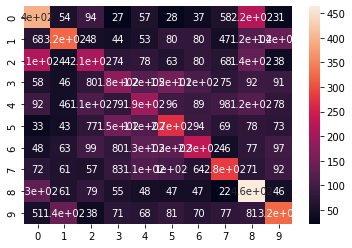

In [ ]:
cm = confusion_matrix(testLb, svcModel.predict(testDt))
sns.heatmap(cm, annot=True)

### Logistic Regression Model

In [ ]:
def LRModel(features,labels):
    model = LogisticRegression(C=0.01,solver='lbfgs')
    model.fit(features,labels)
    return model

In [ ]:
lrModel = LRModel(trainDataset,trainLabels)

In [ ]:
accuracy = lrModel.score(testDt,testLb)

In [ ]:
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 0.2853


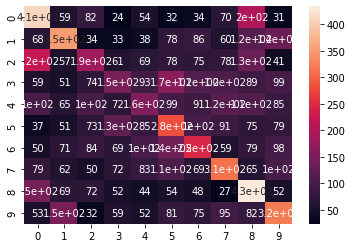

In [ ]:
cm = confusion_matrix(testLb, lrModel.predict(testDt))
sns.heatmap(cm, annot=True)

### KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def KNNModel(features,labels):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(features,labels)
    return model

In [ ]:
knnModel = KNNModel(trainDataset,trainLabels)

In [ ]:
accuracy = knnModel.score(testDt,testLb)

In [ ]:
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 0.1472


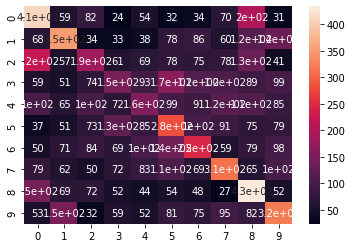

In [ ]:
cm = confusion_matrix(testLb, lrModel.predict(testDt))
sns.heatmap(cm, annot=True)